Import Library

In [2]:
!pip install tf2onnx

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import tf2onnx

Loading Data

In [4]:
df = pd.read_csv('cardio.csv')
df.head()

,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0,0;18393;2;168;62.0;110;80;1;1;0;0;1;0
1,1;20228;1;156;85.0;140;90;3;1;0;0;1;1
2,2;18857;1;165;64.0;130;70;3;1;0;0;0;1
3,3;17623;2;169;82.0;150;100;1;1;0;0;1;1
4,4;17474;1;156;56.0;100;60;1;1;0;0;0;0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 1 columns):
 #   Column                                                                             Non-Null Count  Dtype 
---  ------                                                                             --------------  ----- 
 0   id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio  70000 non-null  object
dtypes: object(1)
memory usage: 547.0+ KB


In [6]:
# Baca file dengan delimiter yang benar agar kolom nya terpisah
df = pd.read_csv('cardio.csv', sep=';')

# Cek apakah kolom sudah terpisah
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None


In [7]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


EDA

In [8]:
# Basic statistic
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.isnull().sum()

,0
id,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0


In [10]:
# Target variable distribution
print(f"\nTarget Variable Distribution:")
target_counts = df['cardio'].value_counts()
print(target_counts)
print(f"Percentage - No Disease: {target_counts[0]/len(df)*100:.1f}%")
print(f"Percentage - Disease: {target_counts[1]/len(df)*100:.1f}%")


Target Variable Distribution:
cardio
0    35021
1    34979
Name: count, dtype: int64
Percentage - No Disease: 50.0%
Percentage - Disease: 50.0%


Text(0.5, 1.0, 'Disease Distribution')

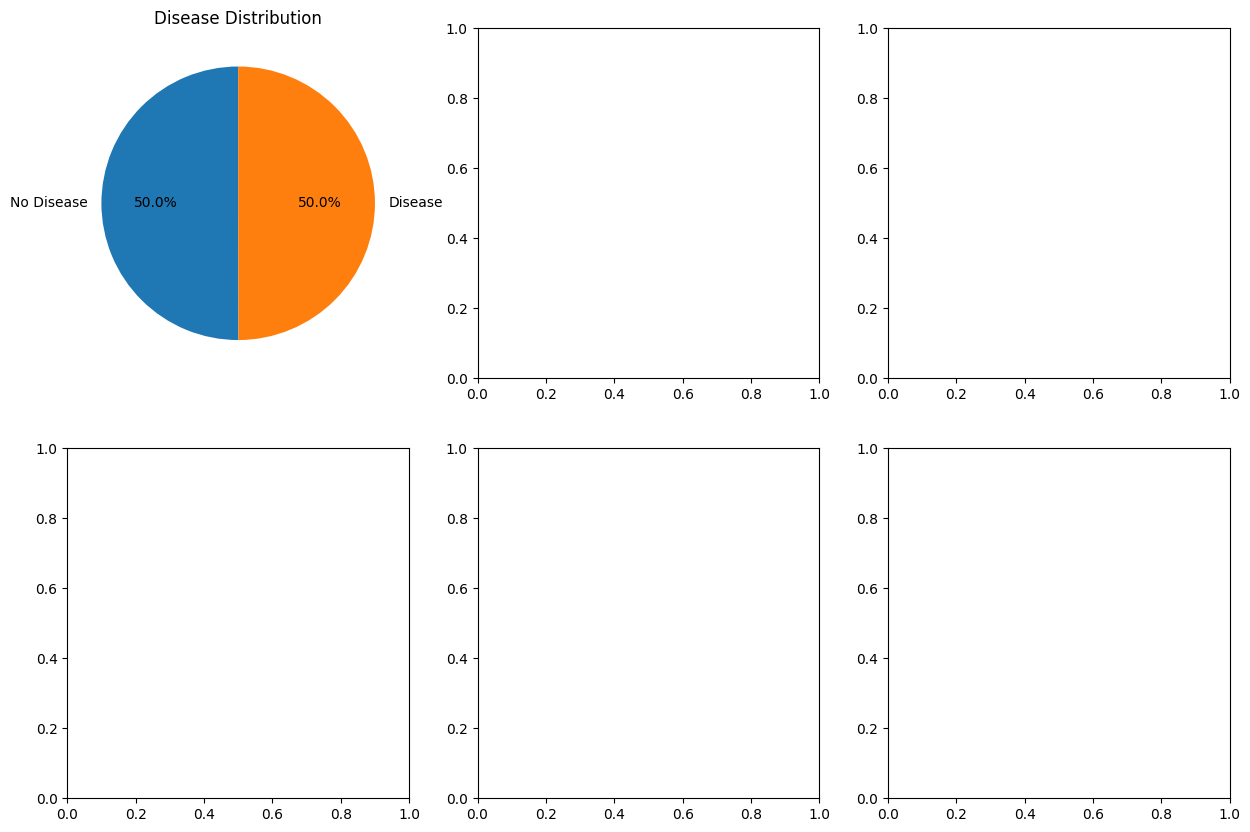

In [14]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Target distribution
axes[0,0].pie(target_counts.values, labels=['No Disease', 'Disease'], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Disease Distribution')

In [18]:
# Age distribution by disease
sns.boxplot(data=df, x='cardio', y='age', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Disease Status')
axes[0,1].set_xlabel('Disease (0: No, 1: Yes)')

Text(0.5, 424.44444444444446, 'Disease (0: No, 1: Yes)')

In [20]:
# Blood pressure analysis
df['bmi'] = df['weight'] / (df['height']/100)**2
sns.scatterplot(data=df, x='ap_hi', y='ap_lo', hue='cardio', alpha=0.6, ax=axes[0,2])
axes[0,2].set_title('Blood Pressure Distribution')
axes[0,2].set_xlabel('Systolic BP')
axes[0,2].set_ylabel('Diastolic BP')

Text(850.5456848409268, 0.5, 'Diastolic BP')

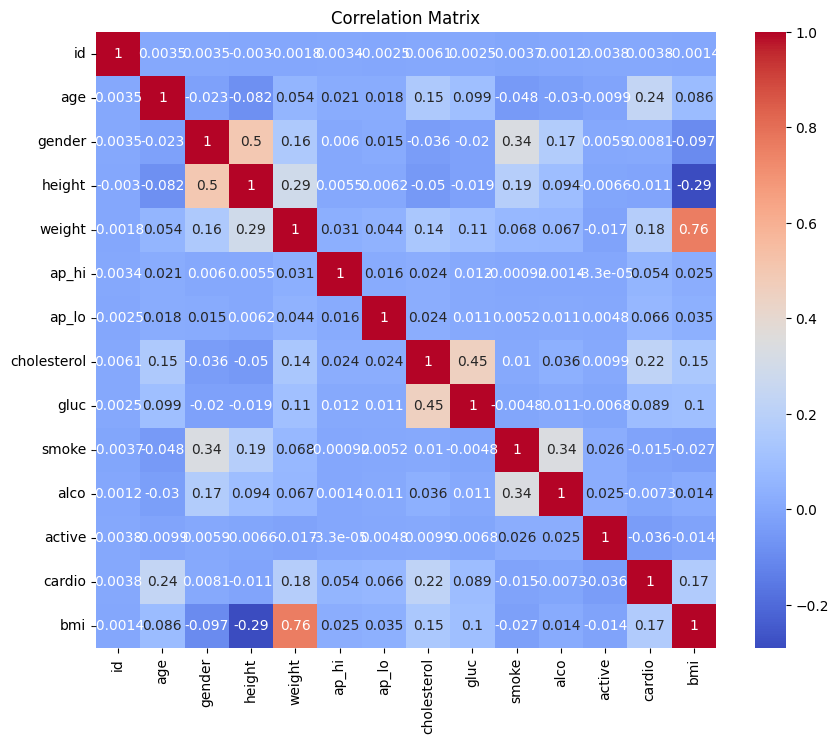

In [22]:
# Correlation heatmap
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

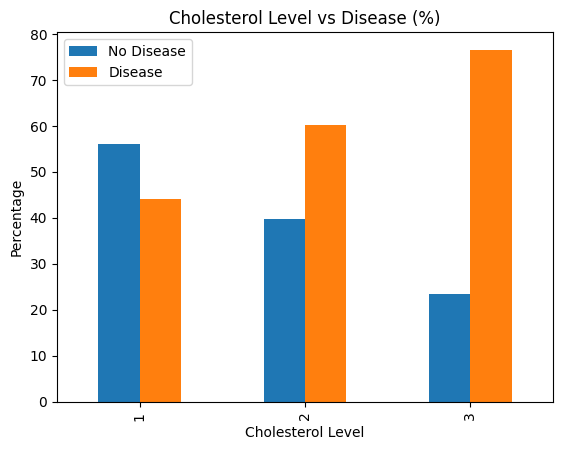

In [27]:
# Cholesterol vs Disease
cholesterol_disease_counts = df.groupby('cholesterol')['cardio'].value_counts().unstack(fill_value=0)
cholesterol_percentage = cholesterol_disease_counts.apply(lambda x: x / x.sum() * 100, axis=1)
cholesterol_percentage.plot(kind='bar')
plt.title('Cholesterol Level vs Disease (%)')
plt.xlabel('Cholesterol Level')
plt.ylabel('Percentage')
plt.legend(['No Disease', 'Disease'])
plt.show()

DATA PREPROCESSING

In [29]:
# Remove outliers (simple method)
def remove_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Clean the data
print("Removing outliers...")
original_shape = df.shape[0]

# Remove extreme outliers for blood pressure and BMI
df = remove_outliers(df, 'ap_hi', 0.01, 0.99)
df = remove_outliers(df, 'ap_lo', 0.01, 0.99)
df = remove_outliers(df, 'bmi', 0.01, 0.99)

print(f"Removed {original_shape - df.shape[0]} outliers")
print(f"Cleaned dataset shape: {df.shape}")

Removing outliers...
Removed 2653 outliers
Cleaned dataset shape: (64904, 14)


In [32]:
# Prepare features and target
print("Preparing features and target...")
# Drop both 'cardio' (target) and 'id' (identifier)
X = df.drop(['cardio', 'id'], axis=1)
y = df['cardio']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Preparing features and target...
Features shape: (64904, 12)
Target shape: (64904,)


In [33]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (51923, 12)
Test set: (12981, 12)


In [34]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


NEURAL NETWORK MODEL

In [36]:
# Build the model
def create_nn_model(input_dim):
    # Use tf.keras instead of keras
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    return model

In [37]:
# Create and display model
# The input dimension will now be 12 (13 original - 1 'id')
model = create_nn_model(X_train_scaled.shape[1])
print("Neural Network Architecture:")
model.summary()

# Add callbacks - Use tf.keras.callbacks instead of keras.callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Train the model
print("Training the model...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Model training completed!")

Neural Network Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

Training the model...
Epoch 1/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6948 - loss: 0.5883 - precision: 0.6941 - recall: 0.6662 - val_accuracy: 0.7242 - val_loss: 0.5573 - val_precision: 0.6990 - val_recall: 0.7600 - learning_rate: 0.0010
Epoch 2/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7243 - loss: 0.5551 - precision: 0.7326 - recall: 0.7002 - val_accuracy: 0.7311 - val_loss: 0.5513 - val_precision: 0.7309 - val_recall: 0.7073 - learning_rate: 0.0010
Epoch 3/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7278 - loss: 0.5522 - precision: 0.7427 - recall: 0.6935 - val_accuracy: 0.7297 - val_loss: 0.5505 - val_precision: 0.7486 - val_recall: 0.6686 - learning_rate: 0.0010
Epoch 4/100
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7290 - loss: 0.5539 - precision: 0.7474 - recall: 0.6760 - val_accuracy: 0.7286 - val_loss: 0.5502 - val_precision: 0.7326 - val_recall: 0.6956 - learning_rate: 0.0010
Epoch 5/100
1299/1299 ━━━━━━━

MODEL EVALUATION

In [38]:
# Make predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics - Need to import accuracy_score and roc_auc_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")

print(f"Classification Report:")
print(classification_report(y_test, y_pred))

406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Accuracy: 0.7318
AUC Score: 0.7955
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6603
           1       0.75      0.68      0.71      6378

    accuracy                           0.73     12981
   macro avg       0.73      0.73      0.73     12981
weighted avg       0.73      0.73      0.73     12981



In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:")
print(cm)

Confusion Matrix:
[[5182 1421]
 [2060 4318]]


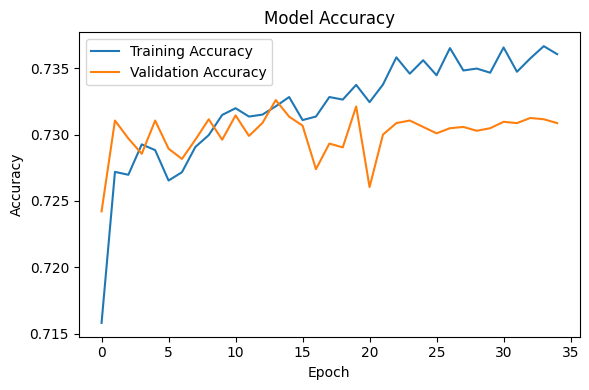

In [45]:
# Training history
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.tight_layout()
plt.show()

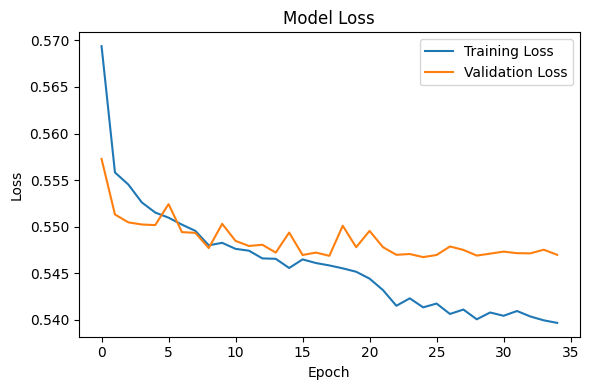

In [46]:
# Loss history
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.tight_layout()
plt.show()

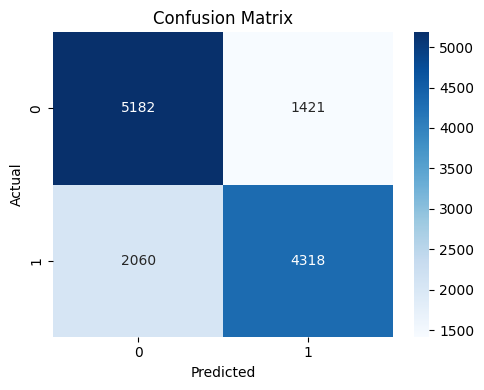

In [47]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(5, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

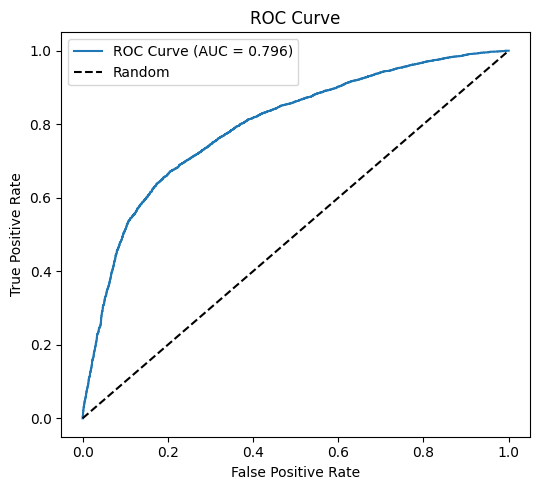

In [49]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(5.5, 5))

ax.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

plt.tight_layout()
plt.show()

SAVE MODEL AND SCALER

In [50]:
# Save the model
model.save('cardio_prediction_model.h5')
print("Model saved as 'cardio_prediction_model.h5'")

Model saved as 'cardio_prediction_model.h5'


In [51]:
# Save the scaler
import joblib
joblib.dump(scaler, 'cardio_scaler.pkl')
print("Scaler saved as 'cardio_scaler.pkl'")

Scaler saved as 'cardio_scaler.pkl'


In [55]:
# Sample prediction function
def predict_cardiovascular_disease(age, gender, height, weight, ap_hi, ap_lo,
                                 cholesterol, gluc, smoke, alco, active):
    """
    Predict cardiovascular disease probability

    Parameters:
    - age: Age in years
    - gender: 0 for female, 1 for male
    - height: Height in cm
    - weight: Weight in kg
    - ap_hi: Systolic blood pressure
    - ap_lo: Diastolic blood pressure
    - cholesterol: 1=normal, 2=above normal, 3=well above normal
    - gluc: 1=normal, 2=above normal, 3=well above normal
    - smoke: 0=no, 1=yes
    - alco: 0=no, 1=yes
    - active: 0=no, 1=yes
    """

    # Create BMI
    bmi = weight / (height/100)**2

    # Prepare input as a dictionary first to ensure column order matches training data
    # The columns should match X after dropping 'id':
    # 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi'
    input_dict = {
        'age': age,
        'gender': gender,
        'height': height,
        'weight': weight,
        'ap_hi': ap_hi,
        'ap_lo': ap_lo,
        'cholesterol': cholesterol,
        'gluc': gluc,
        'smoke': smoke,
        'alco': alco,
        'active': active,
        'bmi': bmi
    }

    # Convert the dictionary to a Pandas DataFrame row
    input_df = pd.DataFrame([input_dict])

    # Scale the input
    # Use the scaler trained on data without the 'id' column
    input_scaled = scaler.transform(input_df)

    # Make prediction
    probability = model.predict(input_scaled)[0][0]
    prediction = "High Risk" if probability > 0.5 else "Low Risk"

    return {
        'probability': float(probability),
        'prediction': prediction,
        'risk_level': 'High' if probability > 0.7 else 'Medium' if probability > 0.3 else 'Low'
    }

# Test the prediction function
print("SAMPLE PREDICTION")
print("-"*25)

sample_result = predict_cardiovascular_disease(
    age=55, gender=1, height=175, weight=80,
    ap_hi=140, ap_lo=90, cholesterol=2, gluc=1,
    smoke=1, alco=0, active=1
)

print(f"Sample Patient Profile:")
print(f"- Age: 55, Male, Height: 175cm, Weight: 80kg")
print(f"- Blood Pressure: 140/90, Cholesterol: Above Normal")
print(f"- Smoker: Yes, Alcohol: No, Active: Yes")
print(f"\nPrediction Results:")
print(f"- Probability: {sample_result['probability']:.1%}")
print(f"- Prediction: {sample_result['prediction']}")
print(f"- Risk Level: {sample_result['risk_level']}")

SAMPLE PREDICTION
-------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Sample Patient Profile:
- Age: 55, Male, Height: 175cm, Weight: 80kg
- Blood Pressure: 140/90, Cholesterol: Above Normal
- Smoker: Yes, Alcohol: No, Active: Yes

Prediction Results:
- Probability: 91.1%
- Prediction: High Risk
- Risk Level: High


In [59]:
# Konversi model ke format ONNX
# Wrap the Sequential model in a functional Model
inputs = tf.keras.Input(shape=(X.shape[1],), name="input")
outputs = model(inputs)
functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)

spec = (tf.TensorSpec((None, X.shape[1]), tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(functional_model, # Use the functional_model
                                           input_signature=spec,
                                           opset=13,
                                           output_path="cardiovascular_model.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x79250229e700>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


In [61]:
print("="*60)
print("CARDIOVASCULAR DISEASE PREDICTION SYSTEM COMPLETED!")
print("="*60)
print(f"Model Accuracy: {accuracy:.1%}")
print(f"AUC Score: {auc_score:.3f}")
print(f"Model and scaler saved successfully")
print(f"Model berhasil dikonversi ke ONNX dan disimpan sebagai cardiovascular_model.onnx")

CARDIOVASCULAR DISEASE PREDICTION SYSTEM COMPLETED!
Model Accuracy: 73.2%
AUC Score: 0.796
Model and scaler saved successfully
Model berhasil dikonversi ke ONNX dan disimpan sebagai cardiovascular_model.onnx
